Issues:
- inflated \# units (e.g. parkmerced) due to double counting or counting non-residential units
- properties in some assessor roll years and not others
   - **solution**: take record from closest year, only consider evictions >= 2007
- properties with multiple rent control eligibility use codes:
   - **solution**: count how many of these there are, take the max use code
- zero-unit buildings in new construction
   - **solution**: year_built < 2010, or units > 0
- properties with multiple year-built's
   - **solution**: take the max year built, which will give a conservative estimate w/r/t rent control
- year-built = 0
   - **solution**: year_built > 1800
- condo conversion or parcel splits after eviction but before earliest assessor record
   - SRES --> MRES would overcount MRES evictions
   - MRES --> SRES would undercount MRES evictions
   - **solution**: only count evictions after 2007
   - many of these are the "0000 0000 000000000" values in assessor rolls
- rent controlled properties more likely to be in state of disrepair and therefore require demolition/capital improvements
   - **solution**: fit hedonic and control for stddev above/below predicted value
- petition applies to multiple units
   - **solution**: use new eviction .csv with unit counts

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

### Load assessor universe

In [2]:
asr = pd.read_csv('evictions/data/asr_grouped_by_yr.csv')

In [3]:
asr['any_ev'] = (asr['ev_count'] > 0).astype(int)
asr['any_ev_07'] = (asr['ev_count_post_07'] > 0).astype(int)
asr['pre_1980'] = (asr['year_built_max'] < 1980)
asr['ev_per_unit'] = asr['ev_count'] / asr['total_units']
asr['ev_per_unit_since_07'] = asr['ev_count_post_07'] / asr['total_units']

### Load eviction data

In [188]:
ev = pd.read_csv('evictions/data/ev_matched.csv')

### Eviction type counts by built year

In [189]:
ev = ev[ev['year'] >= 2007]

In [194]:
num_years = ev['year'].nunique()

In [195]:
ev_per_year = len(ev)/num_years

In [196]:
ev_per_year

2055.3636363636365

In [183]:
ev = ev.merge(asr, left_on='asr_index', right_on='index')
ev.shape

(21588, 50)

In [184]:
ev = ev[ev['any_rc_eligibility'] == 1]
ev.shape

(15329, 50)

In [185]:
ev.loc[pd.isnull(ev['type']), 'type'] = 'unknown'

type_counts = ev.groupby(['pre_1980', 'type']).agg(count=('index_x', 'nunique')).reset_index()
pre_sums = type_counts.groupby('pre_1980')['count'].sum()

In [186]:
type_counts = type_counts.pivot(index='type', columns='pre_1980', values='count')
type_counts['pct_False'] = type_counts[False] / pre_sums[False]
type_counts['pct_True'] = type_counts[True] / pre_sums[True]

#### 8x rate of OMI's, but this is prob due to structural differences

In [187]:
type_counts.sort_values('pct_True', ascending=False).head(20)

pre_1980,False,True,pct_False,pct_True
type,,,,
unknown,47.0,5431.0,0.228155,0.359122
Breach of Lease Agreement,78.0,3303.0,0.378641,0.218409
Nuisance,29.0,1767.0,0.140777,0.116842
OMI,3.0,1251.0,0.014563,0.082722
Capital Improvement,NaN,550.0,NaN,0.036368
Non-payment of Rent,11.0,532.0,0.053398,0.035178
Habitual Late Payment of Rent,4.0,431.0,0.019417,0.028500
ELLIS,NaN,350.0,NaN,0.023144
Development Agreement,NaN,233.0,NaN,0.015407


### Mean differences

#### Evictions post-2007:

In [32]:
mean_diffs = asr[
        (asr['year_built_max'] < 2007) &
        (asr['year_built_min'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
            mean_any_ev=('any_ev_07', 'mean'),
            total_addresses=('index', 'count'),
            total_units=('total_units', 'sum'),
            total_evictions=('ev_count_post_07', 'sum'),
        )

mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

mean_any_ev  total_addresses  total_units  \
any_rc_eligibility pre_1980                                              
0.0                False        0.002014            91369       304098   
                   True         0.002951          1198858      1536290   
1.0                False        0.005958            15106       107832   
                   True         0.018831           365674      1755431   

                             total_evictions  units_per_address  \
any_rc_eligibility pre_1980                                       
0.0                False                 266           3.328240   
                   True                 5784           1.281461   
1.0                False                 180           7.138356   
                   True                14830           4.800535   

                             evictions_per_address  evictions_per_unit  
any_rc_eligibility pre_1980                                             
0.0                False                  0.002911            0.000875  
                   True                   0.004825            0.003765  
1.0                False                  0.011916            0.001669  
                   True                   0.040555            0.008448

#### All Evictions

In [33]:
mean_diffs = asr[
        (asr['year_built_max'] < 2007) &
        (asr['year_built_min'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
            mean_any_ev=('any_ev_07', 'mean'),
            total_addresses=('index', 'count'),
            total_units=('total_units', 'sum'),
            total_evictions=('ev_count', 'sum'),
        )

mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

mean_any_ev  total_addresses  total_units  \
any_rc_eligibility pre_1980                                              
0.0                False        0.002014            91369       304098   
                   True         0.002951          1198858      1536290   
1.0                False        0.005958            15106       107832   
                   True         0.018831           365674      1755431   

                             total_evictions  units_per_address  \
any_rc_eligibility pre_1980                                       
0.0                False                 550           3.328240   
                   True                14027           1.281461   
1.0                False                 386           7.138356   
                   True                28878           4.800535   

                             evictions_per_address  evictions_per_unit  
any_rc_eligibility pre_1980                                             
0.0                False                  0.006020            0.001809  
                   True                   0.011700            0.009130  
1.0                False                  0.025553            0.003580  
                   True                   0.078972            0.016451

### Plots

In [82]:
rc_pop = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1500) &
    (asr['year_built_max'] < 2500) & (asr['total_units'] > 0)]

In [88]:
yr_vs_ev = rc_pop.groupby('year_built_max').agg({
    'ev_per_unit':'mean',
    'ev_per_unit_since_07':'mean'
}).reset_index()

yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                     (yr_vs_ev['year_built_max'] >= 1953)]
yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                     (yr_vs_ev['year_built_max'] <= 2007)]

Text(0.3, 0.8, 'rent control \nbuilt-year threshold')

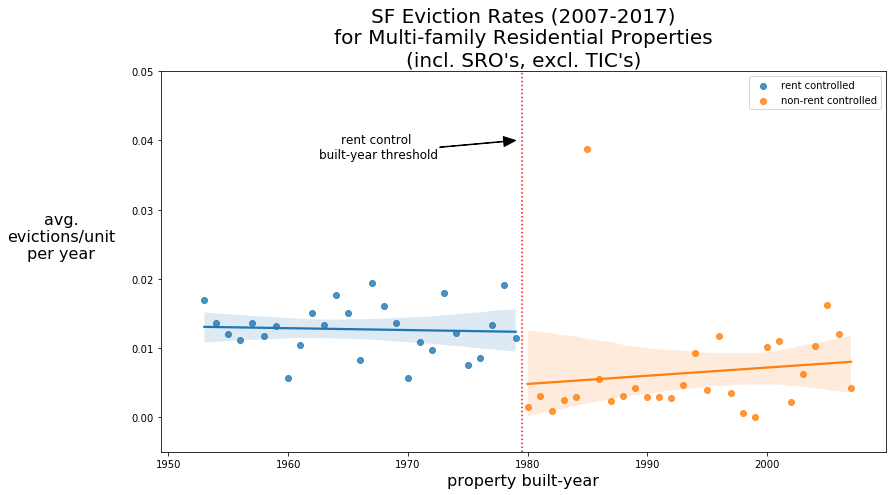

In [304]:
fig, ax = plt.subplots(figsize=(13,7))
sns.regplot('year_built_max', 'ev_per_unit_since_07', yr_vs_ev1, ax=ax, truncate=True, label='rent controlled')
sns.regplot('year_built_max', 'ev_per_unit_since_07', yr_vs_ev2, ax=ax, truncate=True, label='non-rent controlled')
ax.axvline(1979.5, ls=':', c='r')
ax.legend()
_ = ax.set_xlabel("property built-year", fontsize=16)
_ = ax.set_ylabel("avg.\nevictions/unit\nper year", fontsize=16, rotation=0, labelpad=70)
_ = ax.set_title("SF Eviction Rates (2007-2017)\nfor Multi-family Residential Properties\n"
                 "(incl. SRO's, excl. TIC's)", fontsize=20)
ax.set_ylim((-0.005, 0.05))
ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
            xytext=(0.3, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',frac=0.05, width=0.5, headwidth=10),
            horizontalalignment='center', verticalalignment='center', fontsize=12
            )

### Fit Hedonic regression

In [46]:
asr_all = pd.read_csv('./evictions/data/assessor_2007-2018_clean_w_none_sttyps.csv')

/Users/max/opt/anaconda3/envs/evictions/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (1,7,10,16,45) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [47]:
asr_all['total_value'] = asr_all['RP1LNDVAL'] + asr_all['RP1IMPVAL']

In [48]:
asr_all.loc[pd.isnull(asr_all['RP1NBRCDE']), 'RP1NBRCDE'] = 'unknown'

In [49]:
asr_grouped_by_yr = asr_all.groupby(['asr_yr', 'house_1', 'house_2', 'street_name', 'street_type']).agg(
    total_units=('UNITS', 'sum'),
    diff_unit_counts=('UNITS', 'nunique'),
    min_units=('UNITS', 'min'),
    diff_bldg_types=('bldg_type', 'nunique'),
    bldg_type_min=('bldg_type', 'min'),
    bldg_type_max=('bldg_type', 'max'),
    diff_rc_eligibility=('rc_eligible', 'nunique'),
    any_rc_eligibility=('rc_eligible', 'max'),
    diff_years_built=('YRBLT', 'nunique'),
    year_built_min=('YRBLT', 'min'),
    year_built_max=('YRBLT', 'max'),
    total_value=('total_value', 'sum'),
    total_beds=('BEDS', 'sum'),
    total_baths=('BATHS', 'sum'),
    mean_stories=('STOREYNO', 'mean'),
    total_sqft=('SQFT', 'sum'),
    nbd=('RP1NBRCDE', pd.Series.mode),
    total_rooms=('ROOMS', 'sum'),
    total_area=('LAREA', 'sum')
    ).reset_index()

In [93]:
asr_grouped_by_yr['nbd'] = asr_grouped_by_yr['nbd'].apply(lambda x: list(x)[0] if type(x) == np.ndarray else x)

In [94]:
asr_grouped_by_yr['yr_built_since_1900'] = asr_grouped_by_yr['year_built_max'] - 1900

In [95]:
df_hed = asr_grouped_by_yr[
    (asr_grouped_by_yr['any_rc_eligibility'] == 1) &
    (asr_grouped_by_yr['total_units'] > 0) & 
    (asr_grouped_by_yr['year_built_max'] >= 1950) &
    (asr_grouped_by_yr['year_built_max'] <= 2010) &
    (asr_grouped_by_yr['total_sqft'] > 0) &
#     (asr_grouped_by_yr['total_beds'] > 0) 
    (asr_grouped_by_yr['total_baths'] > 0) & 
    (asr_grouped_by_yr['total_rooms'] > 0) &
    (asr_grouped_by_yr['mean_stories'] > 0) &
    (asr_grouped_by_yr['total_area'] > 0)
]

In [96]:
hedonic = smf.ols(
    'total_value ~ total_sqft + np.log1p(total_beds) + np.log1p(total_baths) + np.log1p(total_units) + mean_stories + total_area + '
    'total_rooms + yr_built_since_1900 + C(asr_yr) + nbd', data=df_hed
).fit()

In [97]:
df_hed['hedonic_resid'] = hedonic.resid

<ipython-input-97-50ad7914a310>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hed['hedonic_resid'] = hedonic.resid


In [98]:
print(hedonic.summary())

                            OLS Regression Results                            
Dep. Variable:            total_value   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     6721.
Date:                Sat, 25 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:52:28   Log-Likelihood:            -9.8665e+05
No. Observations:               61479   AIC:                         1.973e+06
Df Residuals:                   61388   BIC:                         1.974e+06
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -1.15e+

### Fitting the sharp RD

Control variables to add:
- rent burden?
- stddev prop value

In [343]:
bandwidth = 27

In [348]:
df = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1980 - bandwidth) &
    (asr['year_built_max'] < 1980 + bandwidth) & (asr['total_units'] > 0)]

In [349]:
df['rent_control'] = False
df.loc[df['pre_1980'] == True, 'rent_control'] = True
df['year_built_centered'] = df['year_built_max'] - 1980

<ipython-input-349-c8926f141828>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rent_control'] = False
<ipython-input-349-c8926f141828>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_built_centered'] = df['year_built_max'] - 1980


In [350]:
df.groupby('pre_1980').agg(
            mean_any_ev=('any_ev', 'mean'),
            total_addresses=('index', 'count'),
            total_units=('total_units', 'sum'),
            total_evictions=('ev_count', 'sum'),
            ev_per_unit=('ev_per_unit', 'mean')
)

,mean_any_ev,total_addresses,total_units,total_evictions,ev_per_unit
pre_1980,,,,,
False,0.014085,14839,112163,378,0.009967
True,0.040188,45461,366136,4150,0.021177


In [351]:
df.columns

Index(['index', 'asr_yr', 'house_1', 'house_2', 'street_name', 'street_type',
       'total_units', 'diff_unit_counts', 'min_units', 'diff_bldg_types',
       'bldg_type_min', 'bldg_type_max', 'diff_rc_eligibility',
       'any_rc_eligibility', 'diff_years_built', 'year_built_min',
       'year_built_max', 'ev_count_post_07', 'ev_count', 'any_ev', 'any_ev_07',
       'pre_1980', 'ev_per_unit', 'ev_per_unit_since_07', 'rent_control',
       'year_built_centered'],
      dtype='object')

In [352]:
df = pd.merge(
    df,
    df_hed[[
        'asr_yr', 'house_1', 'house_2', 'street_name', 'street_type', 'total_rooms',
        'total_value', 'total_area', 'total_sqft', 'nbd', 'total_baths', 'hedonic_resid']],
    on=['asr_yr', 'house_1', 'house_2', 'street_name', 'street_type'])

In [407]:
rd = smf.ols(
    "ev_per_unit_since_07 ~ rent_control + year_built_centered*rent_control + "
    "np.log1p(total_value):np.log(total_sqft) + np.log(total_units)",
    data=df)

In [408]:
fitted = rd.fit()

In [409]:
print(fitted.summary())

                             OLS Regression Results                             
Dep. Variable:     ev_per_unit_since_07   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     67.06
Date:                  Sat, 25 Jan 2020   Prob (F-statistic):           4.26e-70
Time:                          21:57:27   Log-Likelihood:                 22651.
No. Observations:                 54975   AIC:                        -4.529e+04
Df Residuals:                     54969   BIC:                        -4.524e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [201]:
fitted.params[1]

0.01135999854043177

### Potential evictions

In [27]:
units_by_yr = asr[
    (asr['any_rc_eligibility'] == 1) &
    (asr['year_built_max'] > 1900) &
    (asr['year_built_max'] < 2100)].groupby('year_built_max').agg({'total_units': 'sum'}).reset_index()

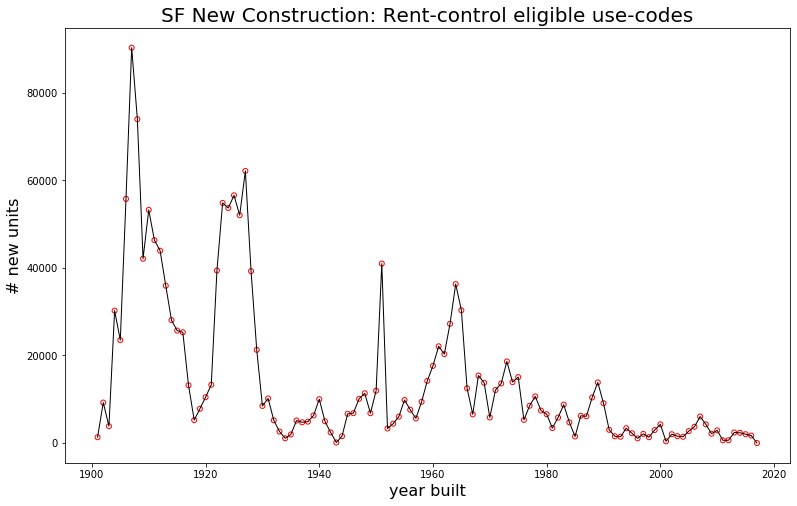

In [28]:
fig, ax = plt.subplots(figsize=(13,8))
ax.scatter(units_by_yr['year_built_max'], units_by_yr['total_units'], s=25, facecolors='none', edgecolors='r')
ax.plot(units_by_yr['year_built_max'], units_by_yr['total_units'], lw=1, c='k', )

_ = ax.set_xlabel("year built", fontsize=16)
_ = ax.set_ylabel("# new units", fontsize=16)
_ = ax.set_title("SF New Construction: Rent-control eligible use-codes", fontsize=20)

In [202]:
rc_pop = asr[(asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1979)]
rc_pop = rc_pop.groupby('year_built_max').agg({'total_units': 'sum'})
rc_pop.index.name = "new rent control year-built cutoff"
rc_pop['cumulative_units'] = rc_pop['total_units'].cumsum()
rc_pop['potential_evictions'] = rc_pop['cumulative_units'] * fitted.params[1]
rc_pop['pct_growth'] = rc_pop['potential_evictions'] / ev_per_year

In [203]:
rc_pop

,total_units,cumulative_units,potential_evictions,pct_growth
new rent control year-built cutoff,,,,
1980,6609,6609,75.078230,0.036528
1981,3442,10051,114.179345,0.055552
1982,5821,15872,180.305897,0.087725
1983,8781,24653,280.058044,0.136257
1984,4738,29391,333.881717,0.162444
1985,1523,30914,351.182995,0.170862
1986,6233,37147,421.989866,0.205312
1987,6134,43281,491.672097,0.239214
1988,10418,53699,610.020562,0.296794


### RDD package

In [7]:
import rdd